In [1]:
import h5py 
import numpy as np
import pandas as pd
import os
import peakutils
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.optimize import curve_fit
from numpy.polynomial.polynomial import Polynomial
from scipy.interpolate import UnivariateSpline

In [2]:
# modified for BBC

def read_fp_and_behavior(folder_path, folder2):
    behaviorDict = {}
    for filename in os.listdir(folder2):
        if filename.endswith('.txt'):
            animals = filename.split('-')[3].split('_')
            Date = filename.split('_')[0]
            session = filename.split('_')[1].split('-')[0]
            # want to make nested dictionary with filename as key, and 'animal', 'date', 'session' as keys in nested dictionary
            behaviorDict[filename] = {'animal': animals, 'date': Date, 'session': session}

    print(behaviorDict)

    dfs = []
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.doric'):
            file_path = os.path.join(folder_path, file_name)
            with h5py.File(file_path, 'r') as f:
                print(file_name)
                roi_names = file_name.split('-')[3].split('_')
                sess = file_name.split('_')[1].split('-')[0]
                date = file_name.split('_')[0]
                # print(roi_names)
                # print(session)
                dio = 'DataAcquisition/BBC300/Signals/Series0001/DigitalIO/Camera1'
                dioT = 'DataAcquisition/BBC300/Signals/Series0001/DigitalIO/Time'
                dio_data = f[dio][()]
                dio_time = f[dioT][()]
                # find all indexes where dio goes from 0 to 1
                rising_edges = np.where(np.diff(dio_data) == 1)[0]
                # get times corresponding to rising edges
                rising_edge_times = dio_time[rising_edges]

                for i,name in enumerate(roi_names):
                    anCol = f'{name}_{sess}'
                    print(anCol)
                    if name != 'XX':
                        df_temp = pd.DataFrame()
                        roi = f'DataAcquisition/BBC300/ROISignals/Series0001/CAM1EXC1/ROI0{i+1}'
                        roi_data = f[roi][()]
                        roi_time = f['DataAcquisition/BBC300/ROISignals/Series0001/CAM1EXC1/Time'][()]
                        frame = np.searchsorted(rising_edge_times, roi_time, side='right')
                        df_temp['Animal'] = [anCol]*len(roi_time)
                        df_temp['Time'] = roi_time
                        df_temp['490nm'] = roi_data
                        df_temp['Frame'] = frame
                        # print(df_temp)

                        # find the key in behaviorDict that matches the animal, date, and session
                        for key in behaviorDict:
                            if name in behaviorDict[key]['animal'] and behaviorDict[key]['date'] == date and behaviorDict[key]['session'] == sess:
                                behavior_file = key
                                # print(behavior_file)
                                break
                            else:
                                behavior_file = None
                                # if the behavior file is not found, continue to the next iteration
                                continue
                        if behavior_file is not None:
                            print(behavior_file)
                            behavior_path = os.path.join(folder2, behavior_file)
                            behavior = pd.read_csv(behavior_path,sep=r'\s+', names = ['Frame','Speaker','Action','Reward','Lick','Disp'])
                            # merge the behavior data with the imaging data
                            df_temp = pd.merge(df_temp, behavior, on='Frame', how='left')
                            # print(df_temp)
                            dfs.append(df_temp)
    df = pd.concat(dfs).reset_index(drop=True)
    return df       

df = read_fp_and_behavior('C:/Users/roshgadolj/Box/Tian Lab Data/Jacob/2024-2025 MPFI/2025-2 dLight Reward Photometry/', 'C:/Users/roshgadolj/Box/Tian Lab Data/Jacob/2024-2025 MPFI/2025-2 dLight Reward State/')

{'2025-2-13_reward1-m3nac38_m3pfc38-.txt': {'animal': ['m3nac38', 'm3pfc38'], 'date': '2025-2-13', 'session': 'reward1'}, '2025-2-13_reward1-m4nac36_m4pfc36-.txt': {'animal': ['m4nac36', 'm4pfc36'], 'date': '2025-2-13', 'session': 'reward1'}, '2025-2-13_reward1-m5nac36_m5pfc36-.txt': {'animal': ['m5nac36', 'm5pfc36'], 'date': '2025-2-13', 'session': 'reward1'}, '2025-2-15_reward3-m1nac38_m1pfc38-.txt': {'animal': ['m1nac38', 'm1pfc38'], 'date': '2025-2-15', 'session': 'reward3'}, '2025-2-15_reward3-m2nac38_m2pfc38-.txt': {'animal': ['m2nac38', 'm2pfc38'], 'date': '2025-2-15', 'session': 'reward3'}, '2025-2-15_reward3-m3nac38a_m3pfc38a-.txt': {'animal': ['m3nac38a', 'm3pfc38a'], 'date': '2025-2-15', 'session': 'reward3'}, '2025-2-15_reward3-m3nac38_m3pfc38-.txt': {'animal': ['m3nac38', 'm3pfc38'], 'date': '2025-2-15', 'session': 'reward3'}, '2025-2-15_reward3-m4nac36_m4pfc36-.txt': {'animal': ['m4nac36', 'm4pfc36'], 'date': '2025-2-15', 'session': 'reward3'}, '2025-2-15_reward3-m5nac36_

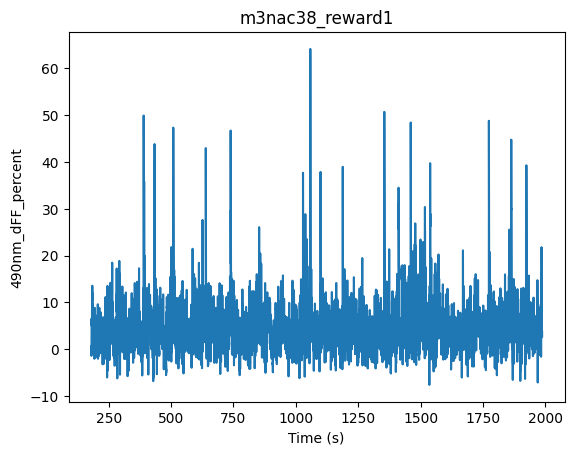

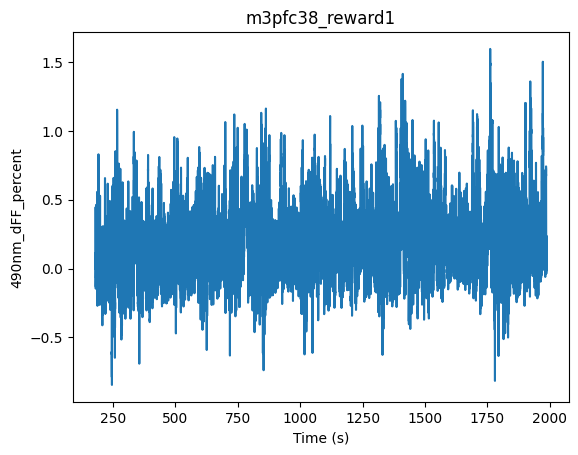

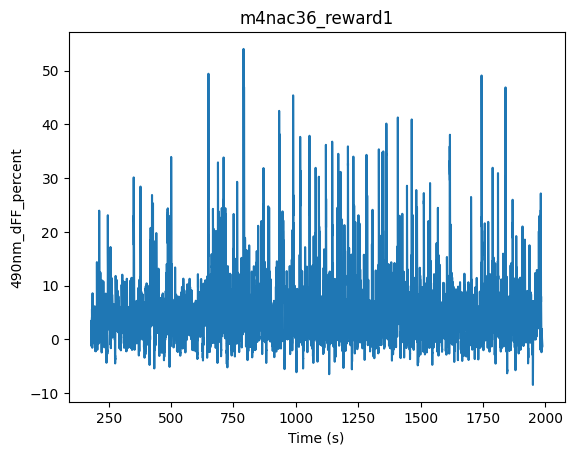

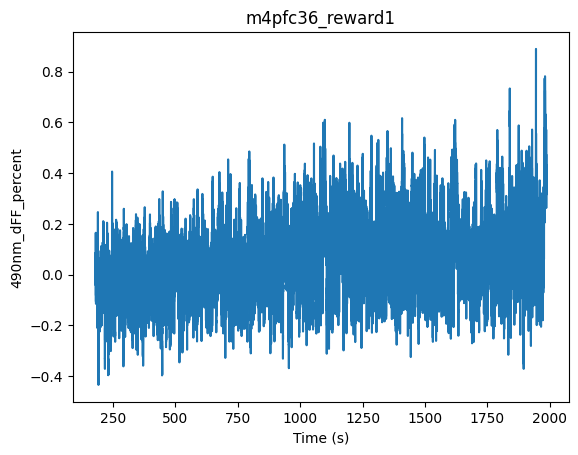

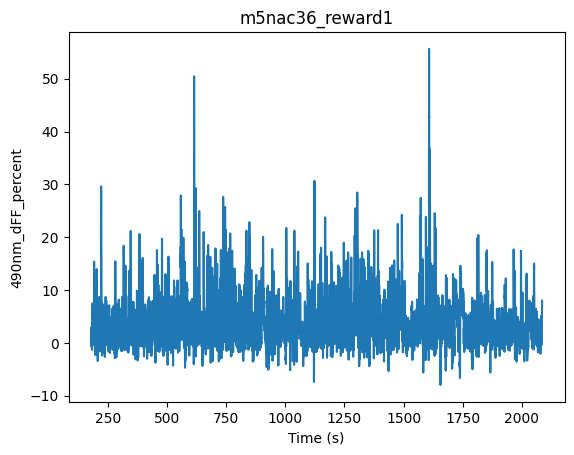

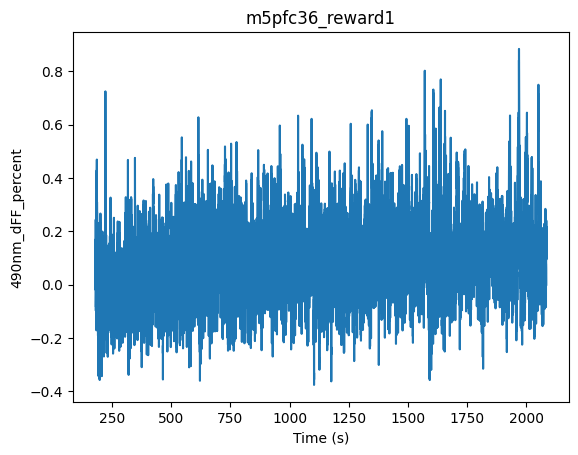

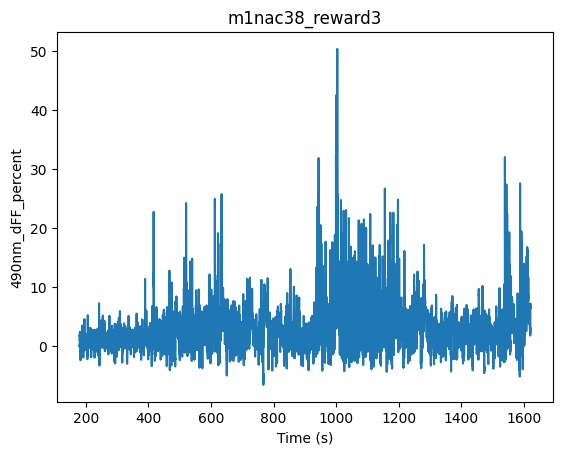

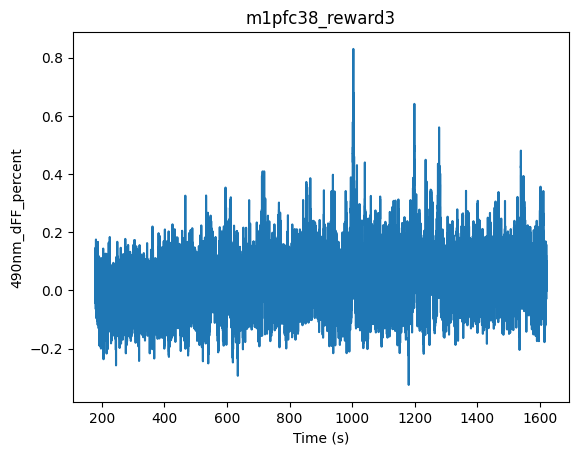

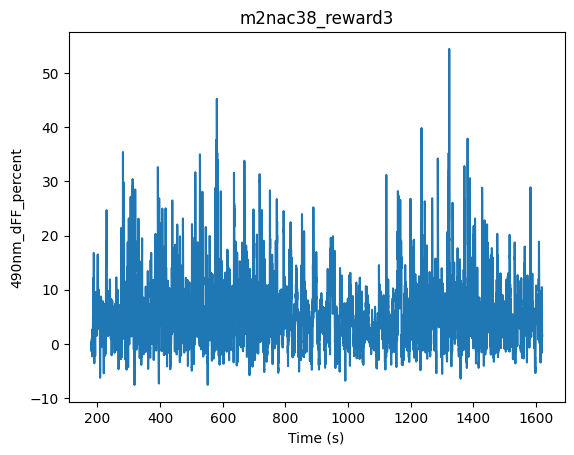

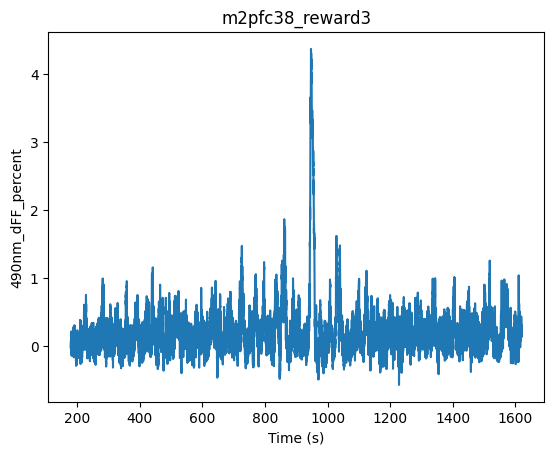

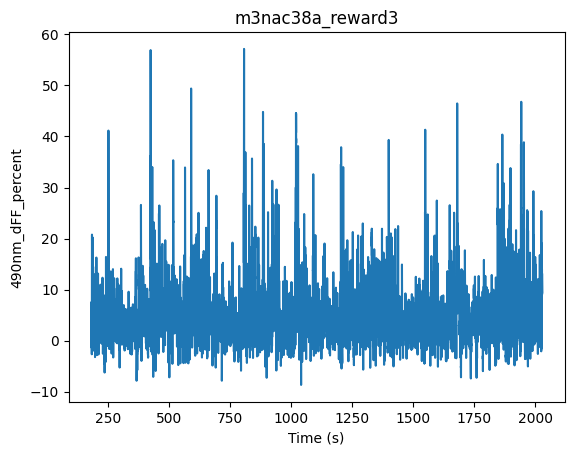

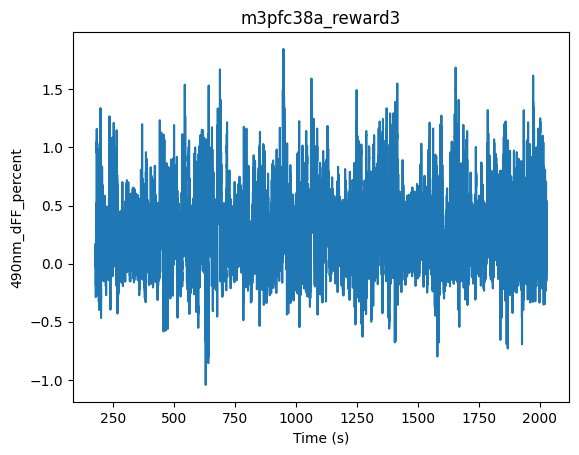

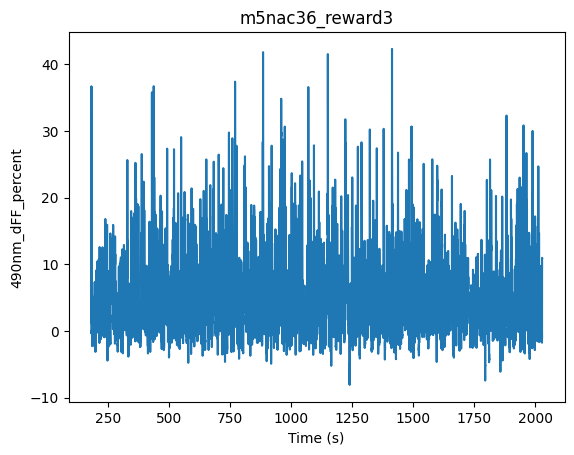

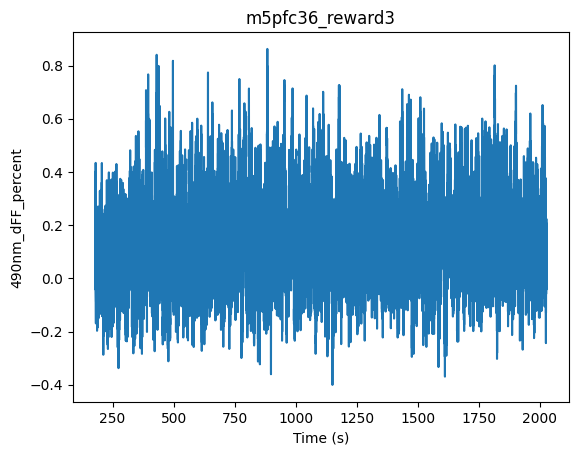

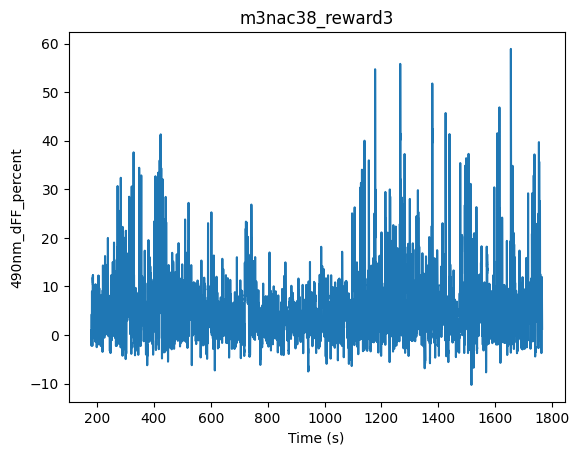

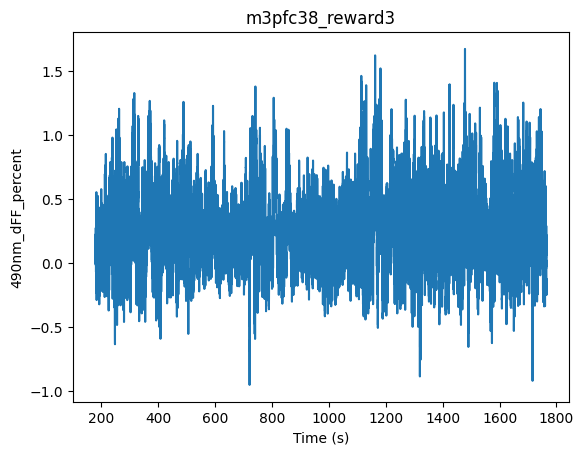

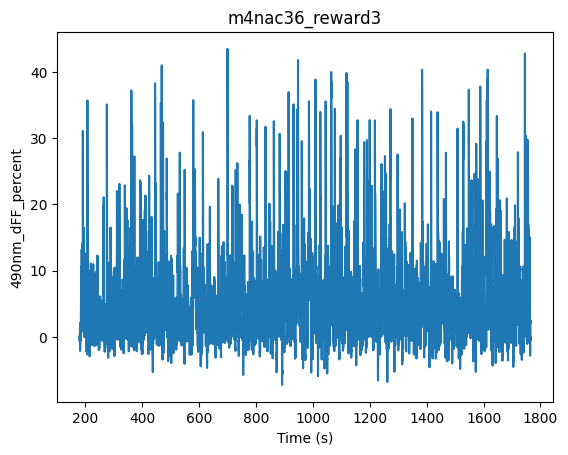

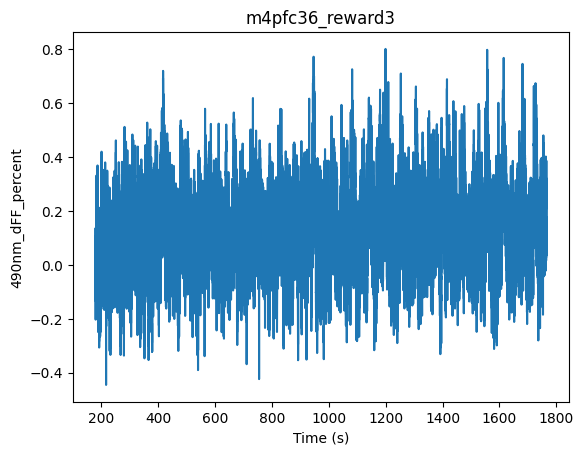

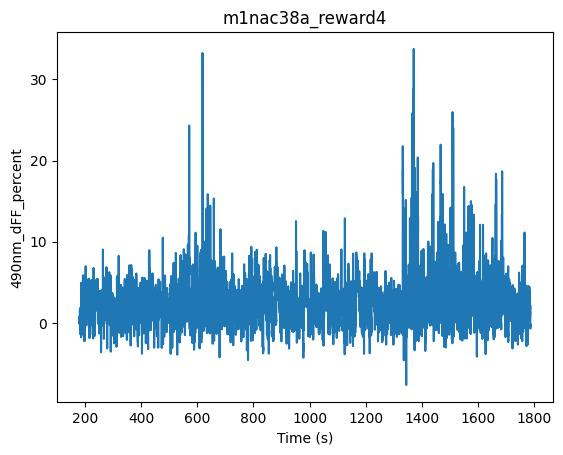

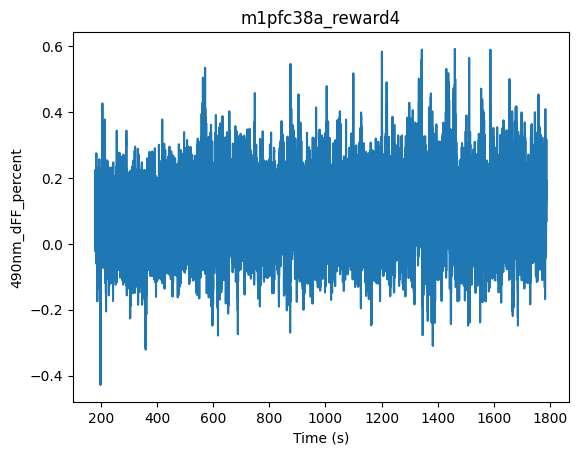

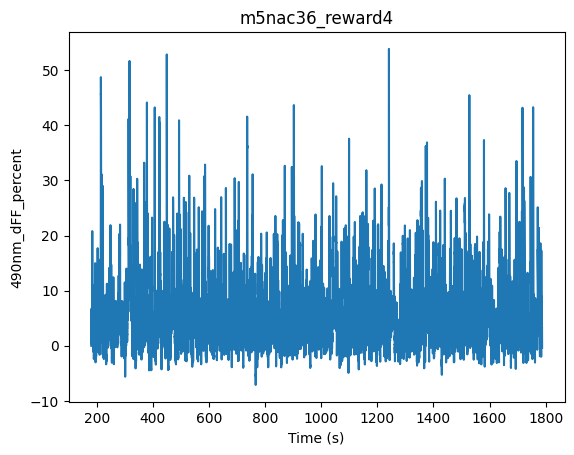

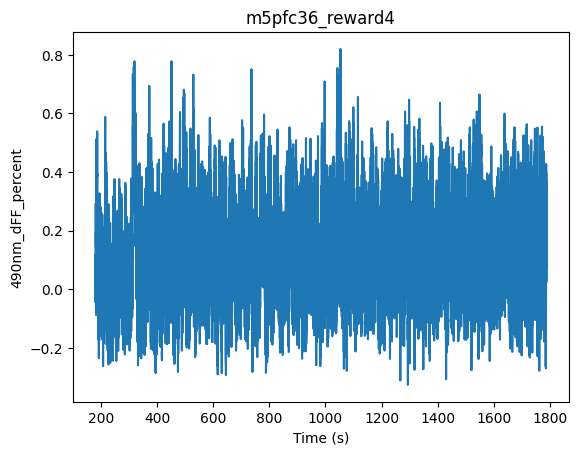

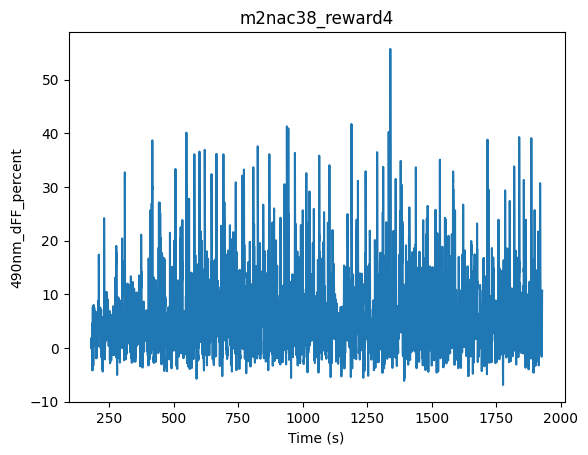

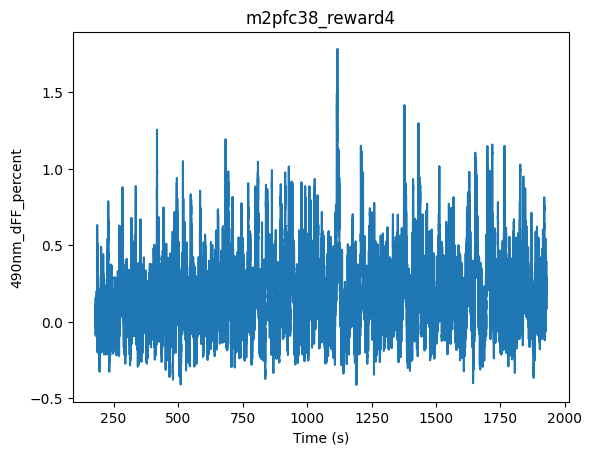

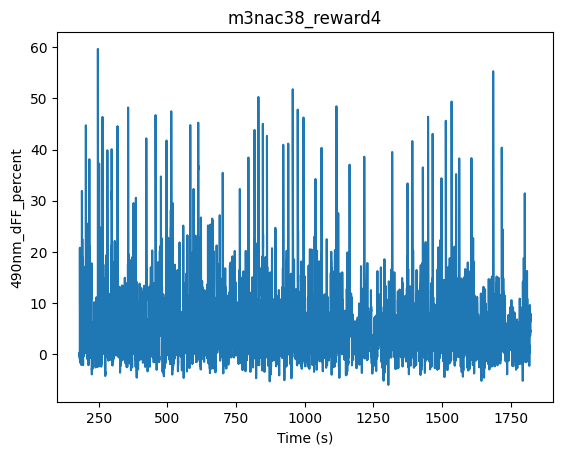

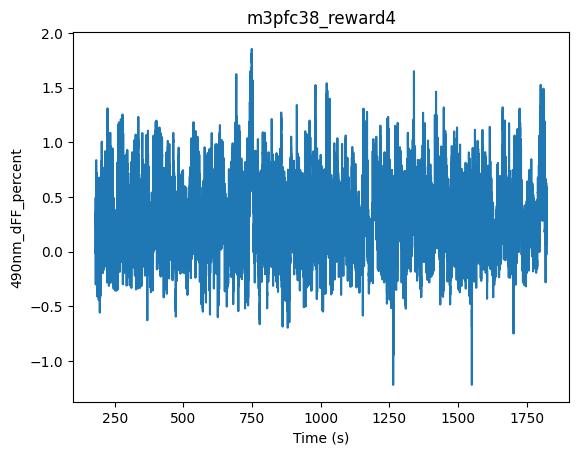

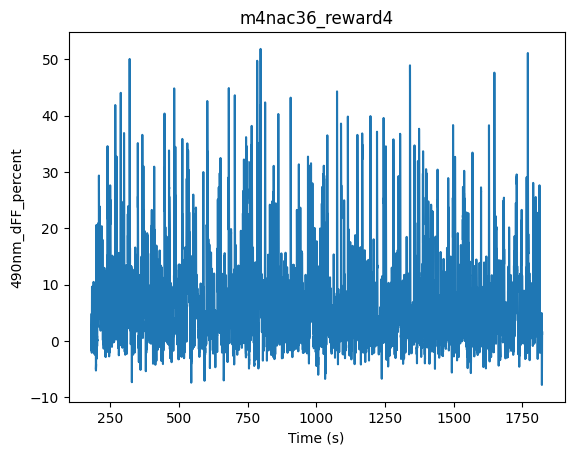

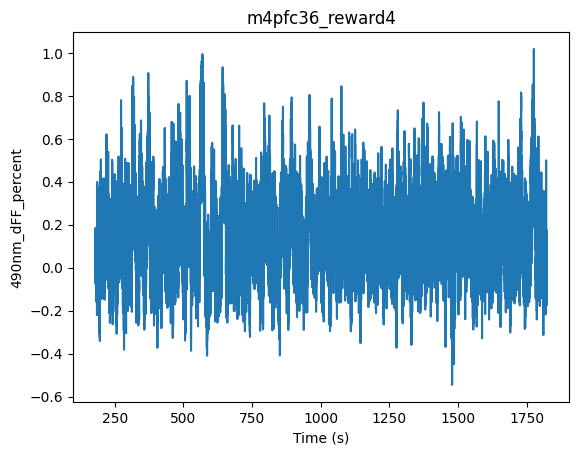

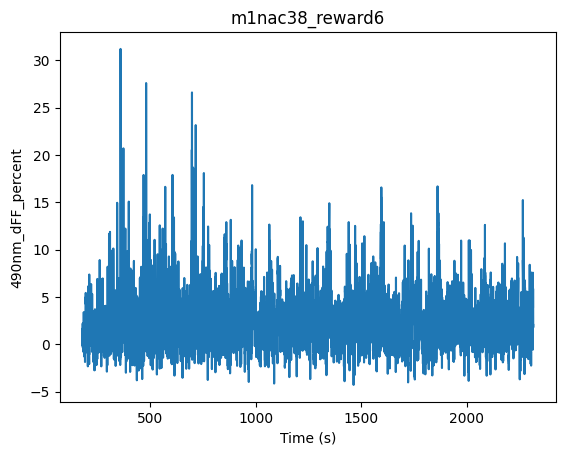

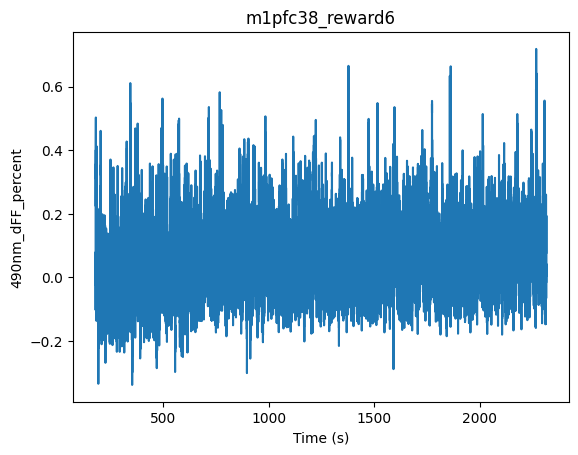

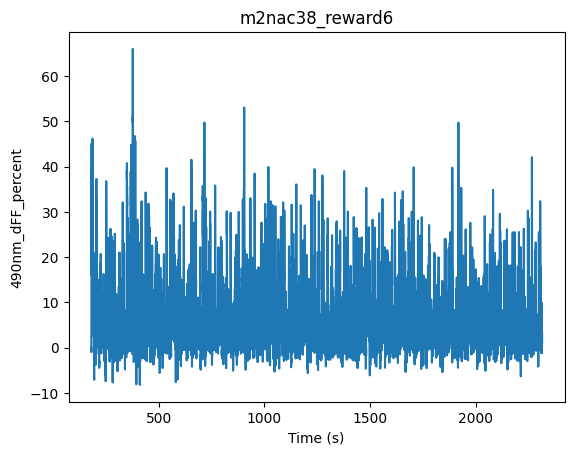

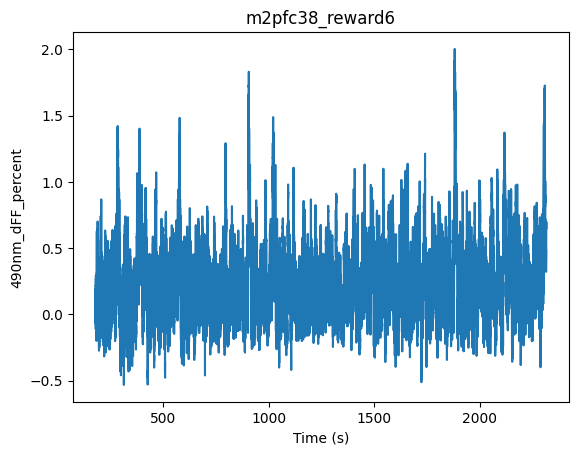

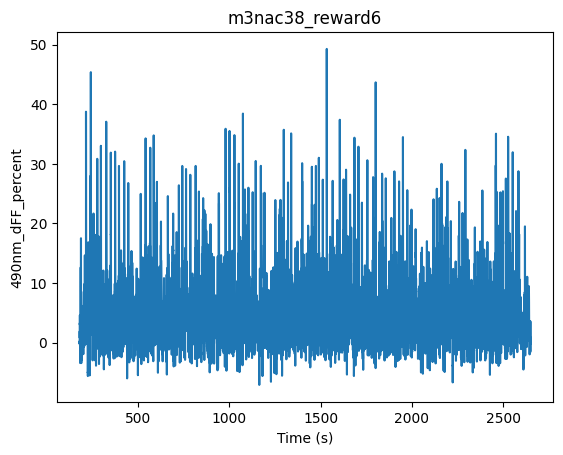

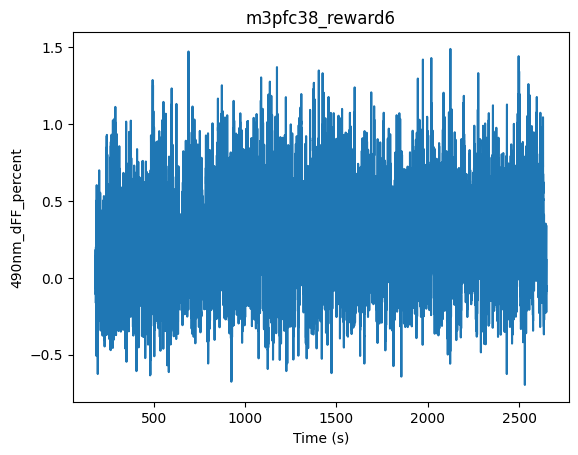

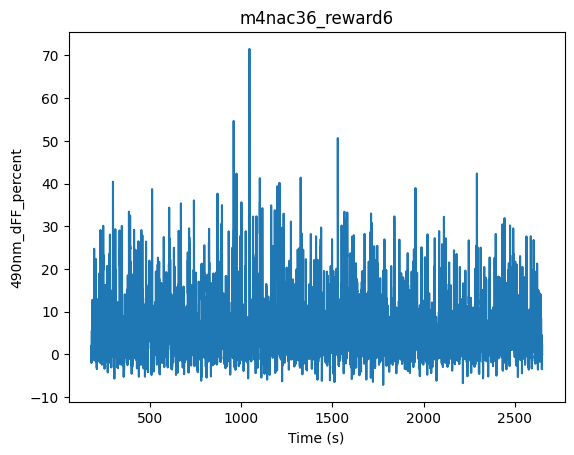

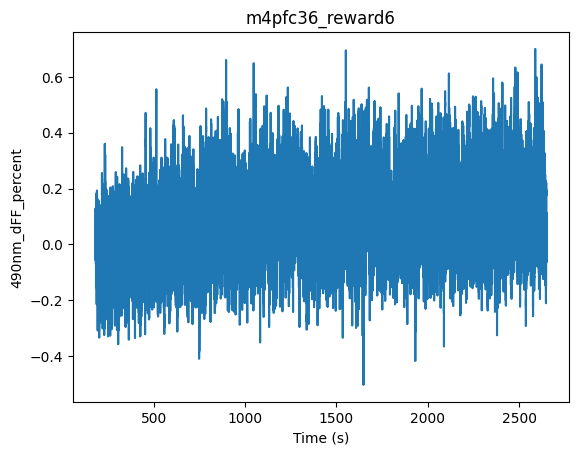

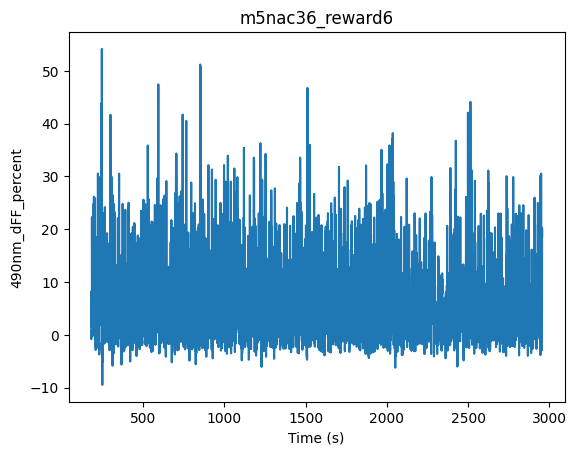

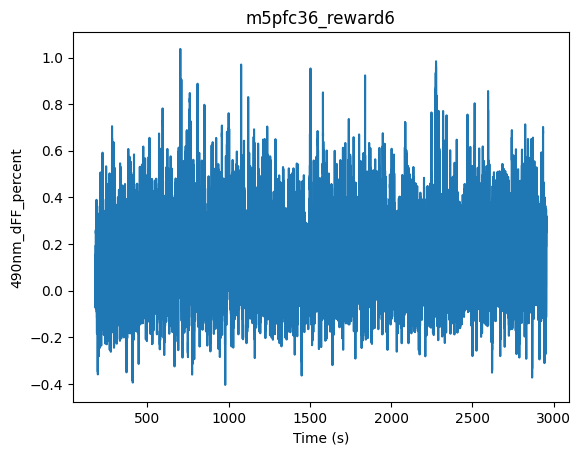

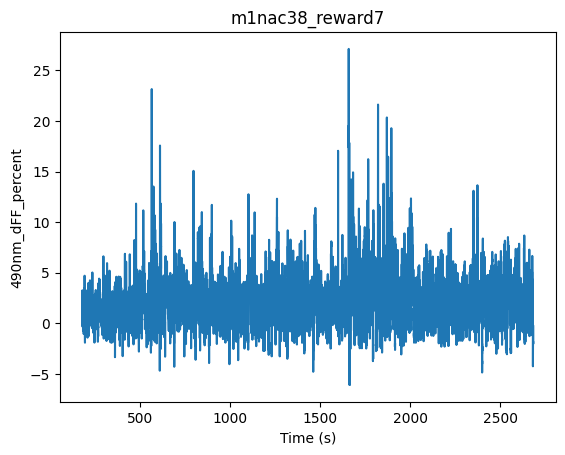

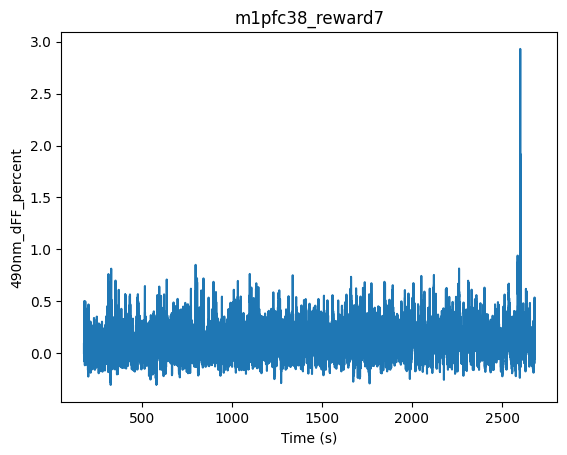

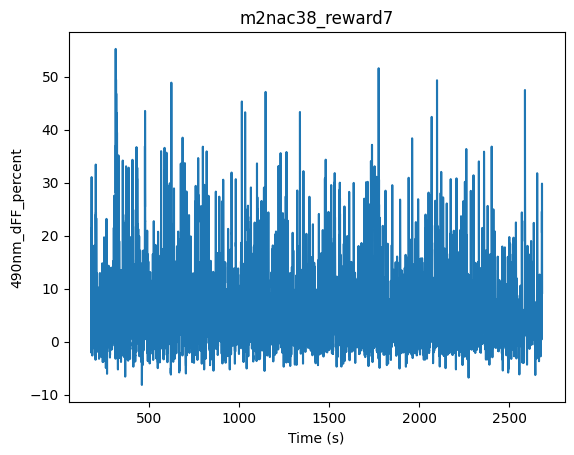

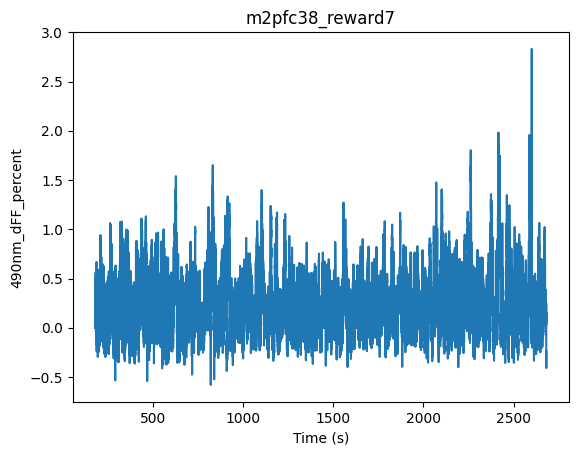

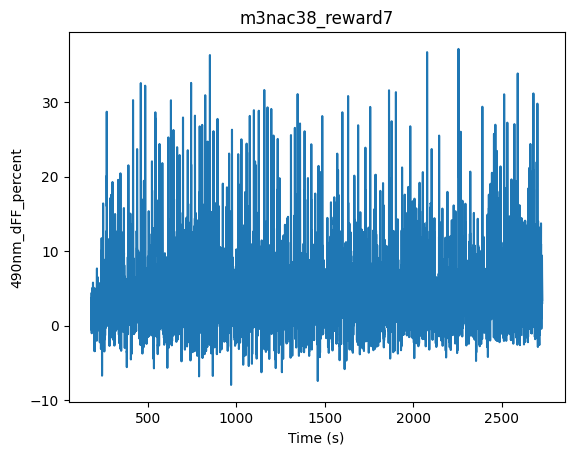

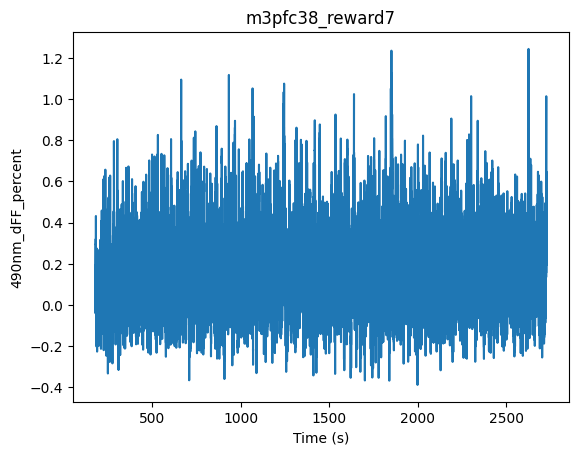

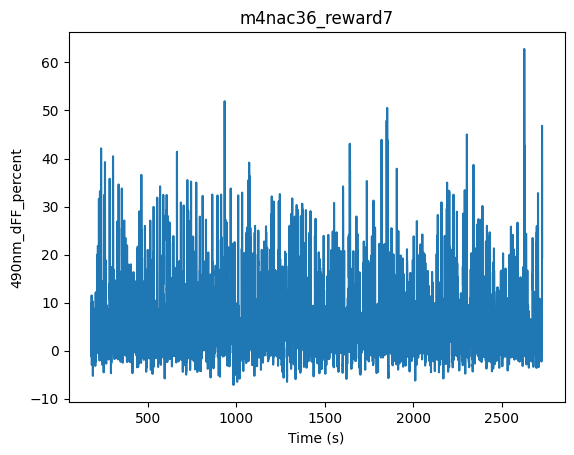

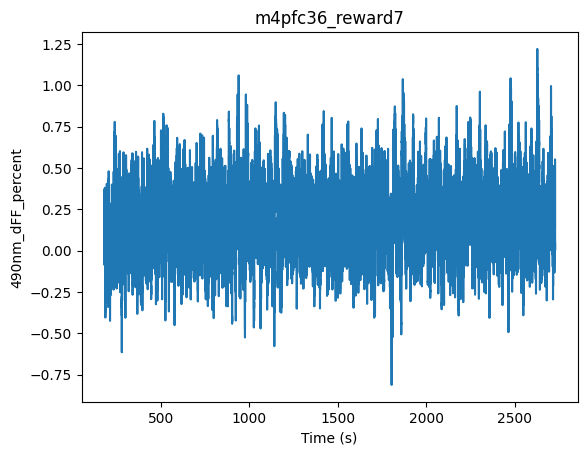

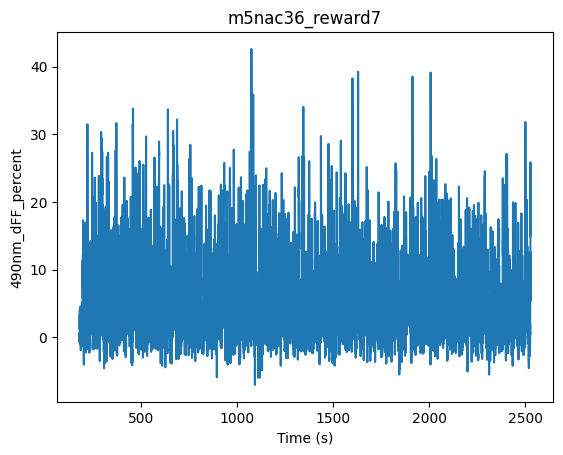

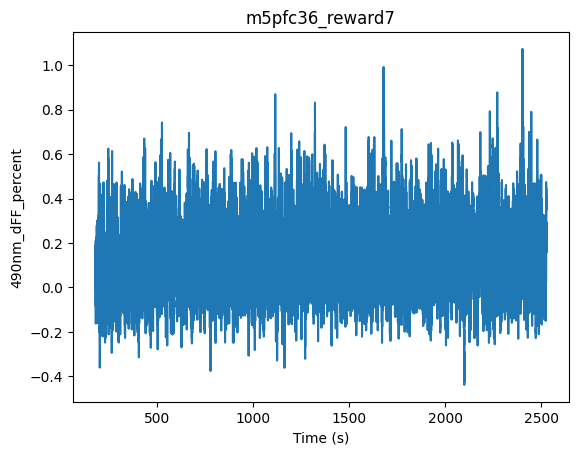

In [84]:
def plot_animal_data(df, yvar):
    for animal in df['Animal'].unique():
        df_animal = df[df['Animal'] == animal]
        plt.figure()
        plt.plot(df_animal['Time'], df_animal[yvar])
        plt.title(animal)
        plt.xlabel('Time (s)')
        plt.ylabel(yvar)
        plt.show()

# Example usage:
plot_animal_data(df_rolling, '490nm_dFF_percent')

In [67]:
def rolling_percentile_fit(df, fit, window=500, percentile=0.1):
    for idx in df['Animal'].unique():
        X = df.loc[df['Animal'] == idx, 'Time']
        Y = df.loc[df['Animal'] == idx, fit]
        
        # Calculate the rolling 10% percentile baseline
        rolling_baseline = Y.rolling(window=window, min_periods=1).quantile(percentile)
        
        df.loc[df['Animal'] == idx, f'{fit}_baseline'] = rolling_baseline
        dFFBaseline = 100 * ((Y - rolling_baseline) / rolling_baseline)
        df.loc[df['Animal'] == idx, f'{fit}_dFF_percent'] = dFFBaseline
        df.loc[df['Animal'] == idx, f'{fit}_dFF_percent_zscore'] = stats.zscore(dFFBaseline, ddof=1)

    return df

In [68]:
df_rolling = rolling_percentile_fit(df, '490nm')

In [72]:
def extractTrials(df):
    df_trial = []
    
    for animal in df['Animal'].unique():
        print(animal)
        df_animal = df.loc[df['Animal']==animal].copy()
        lightOn = df_animal.loc[(df_animal['Speaker']==1) & (df_animal['Speaker'].diff() != 0)]['Time'].tolist()
        lightOn.pop(0) # remove first index because it is the beginning of the session
        trialCnt = 0
        # A trial will be defined as the five seconds before the light turns on and the five seconds preceding
        # the next light turning on

        for i, time in enumerate(lightOn):
            if i == len(lightOn)-1:
                break
            # print(round((lightOn[i+1]-5)-(lightOn[i]-5),2))
            trial = df_animal.loc[(df_animal['Time'] >= (time-5.)) & (df_animal['Time'] <= (lightOn[i+1]-5.))].copy()
            trial['trial time'] = round((trial['Time']-lightOn[i]),3)
            trialCnt += 1
            trial['trial'] = trialCnt
            df_trial.append(trial)
        print(animal, trialCnt)

    df_trial = pd.concat(df_trial).reset_index(drop=True)

    return df_trial

In [73]:
df_trial = extractTrials(df_baseline)

m3nac38_reward1
m3nac38_reward1 13
m3pfc38_reward1
m3pfc38_reward1 13
m4nac36_reward1
m4nac36_reward1 32
m4pfc36_reward1
m4pfc36_reward1 32
m5nac36_reward1
m5nac36_reward1 23
m5pfc36_reward1
m5pfc36_reward1 23
m1nac38_reward3
m1nac38_reward3 0
m1pfc38_reward3
m1pfc38_reward3 0
m2nac38_reward3
m2nac38_reward3 22
m2pfc38_reward3
m2pfc38_reward3 22
m3nac38a_reward3
m3nac38a_reward3 9
m3pfc38a_reward3
m3pfc38a_reward3 9
m5nac36_reward3
m5nac36_reward3 43
m5pfc36_reward3
m5pfc36_reward3 43
m3nac38_reward3
m3nac38_reward3 7
m3pfc38_reward3
m3pfc38_reward3 7
m4nac36_reward3
m4nac36_reward3 38
m4pfc36_reward3
m4pfc36_reward3 38
m1nac38a_reward4
m1nac38a_reward4 0
m1pfc38a_reward4
m1pfc38a_reward4 0
m5nac36_reward4
m5nac36_reward4 37
m5pfc36_reward4
m5pfc36_reward4 37
m2nac38_reward4
m2nac38_reward4 46
m2pfc38_reward4
m2pfc38_reward4 46
m3nac38_reward4
m3nac38_reward4 40
m3pfc38_reward4
m3pfc38_reward4 40
m4nac36_reward4
m4nac36_reward4 34
m4pfc36_reward4
m4pfc36_reward4 34
m1nac38_reward6
m1na

In [74]:
def RewardGroupsDF(df, groups):
    # fig, ax = plt.subplots(1, 1, figsize=(5, 4))
    dfAll=[]
    for group in groups:
        dfReward = []
        df_group = df.loc[df['Animal'].str.contains(group)].copy()
        for animal in df_group['Animal'].unique():
            df_animal = df_group.loc[df_group['Animal'] == animal].copy()
            max_trial = df_animal['trial'].max()
            if max_trial == 0:
                continue
            else:
                for trial in df_animal['trial'].unique():
                    df_trial = df_animal.loc[df_animal['trial'] == trial].copy()
                    # print(animal, trial)
                    try:
                        rewardTime = df_trial.loc[(df_trial['Disp'] == 1) & (df_trial['Disp'].diff() != 0), 'trial time'].tolist()[0]
                    except:
                        # do next trial
                        continue
                    reward = df_trial.loc[(df_trial['trial time'] >= rewardTime - 2.5) & (df_trial['trial time'] <= (rewardTime + 2.5))].copy()
                    reward['poke time'] = round((reward['trial time'] - rewardTime),3)
                    dfReward.append(reward)
                    
        dfReward = pd.concat(dfReward).reset_index(drop=True)
        dfAll.append(dfReward)

    dfAll = pd.concat(dfAll).reset_index(drop=True)
    return dfAll

In [75]:
df_reward = RewardGroupsDF(df_trial, ['pfc','nac'])

In [33]:
# write a function that will apply a vertical shift to the yvar column for each trial by making the mean of the trial baseline period 0

def yvarShift(df,yvar):
    df_shift = []
    for animal in df['Animal'].unique():
        df_animal = df.loc[df['Animal']==animal].copy()
        for trial in df_animal['trial'].unique():
            df_trial = df_animal.loc[df_animal['trial']==trial].copy()
            baselineMean = np.mean(df_trial.loc[(df_trial['poke time']<=0)][yvar].tolist()[-3:])
            df_trial[f'{yvar}_shift'] = df_trial[yvar] - baselineMean
            df_shift.append(df_trial)
    df_shift = pd.concat(df_shift).reset_index(drop=True)
    return df_shift

In [76]:
df_reward_shift = yvarShift(df_reward, '490nm_dFF_percent')

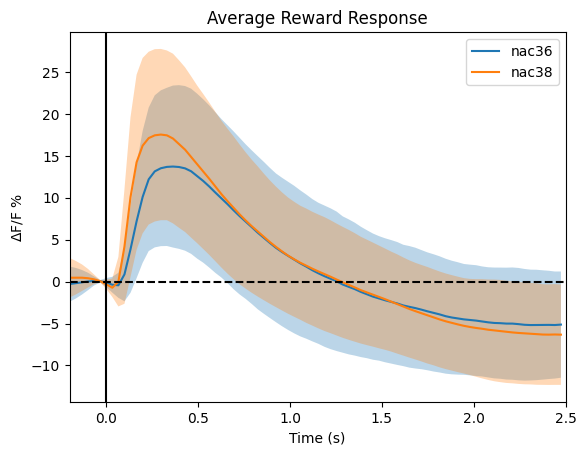

In [77]:
def plot_average_reward_response(df, averages, yvar):
    plt.figure()
    for animal in averages:
        df_animal = df.loc[df['Animal'].str.contains(animal)].copy()
        # only keep 'poke time' and the specified yvar column
        df_animal = df_animal[['poke time', yvar]]
        df_animal_mean = df_animal.groupby('poke time').mean().reset_index()
        df_animal_std = df_animal.groupby('poke time').std().reset_index()
        plt.plot(df_animal_mean['poke time'], df_animal_mean[yvar], label=animal)
        plt.fill_between(df_animal_mean['poke time'], df_animal_mean[yvar] - df_animal_std[yvar], df_animal_mean[yvar] + df_animal_std[yvar], alpha=0.3)
    plt.xlabel('Time (s)')
    plt.legend()
    plt.ylabel(r'$\Delta$F/F %')
    plt.title('Average Reward Response')
    # add horizontal and vertical lines at 0
    plt.axhline(y=0, color='black', linestyle='--')
    plt.axvline(x=0, color='black', linestyle='-')
    plt.xlim(-.2, 2.5)
    plt.show()

# Example usage:
averages = ['nac36', 'nac38']
plot_average_reward_response(df_reward_shift, averages, '490nm_dFF_percent_shift')

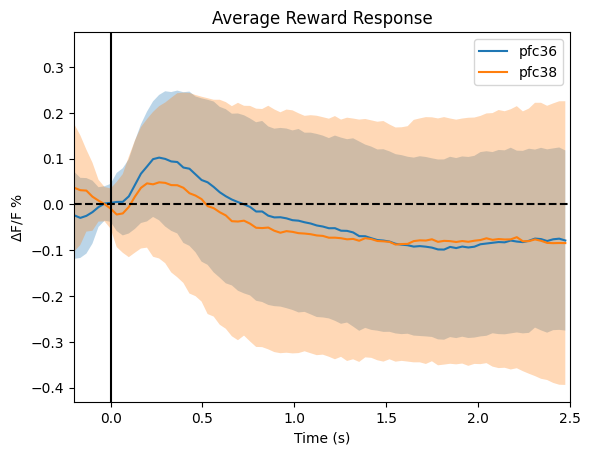

In [78]:
averages = ['pfc36', 'pfc38']
plot_average_reward_response(df_reward_shift, averages, '490nm_dFF_percent_shift')

In [240]:
def peakTrials(df, yvar, groups):
    data = {}
    for group in groups:
        df_group = df.loc[df['Animal'].str.contains(group)].copy()
        for animal in df_group['Animal'].unique():
            df_animal = df_group.loc[df_group['Animal'] == animal].copy()
            for trial in df_animal['trial'].unique():
                df_trial = df_animal.loc[df_animal['trial'] == trial].copy()
                rewardTime = df_trial.loc[(df_trial['Disp'] == 1) & (df_trial['Disp'].diff() != 0), 'trial time'].tolist()[0]
                reward = df_trial.loc[(df_trial['trial time'] >= rewardTime)].copy()
                # find where the max yvar value occurs
                peakTime = reward[yvar].idxmax()
                peak = reward.loc[peakTime, yvar]
                if animal in data:
                    data[animal].append(peak)
                else:
                    data[animal] = [peak]
    # restructure data into a dataframe
    #find longest list of peaks
    maxLen = max([len(data[animal]) for animal in data])
    for animal in data:
        if len(data[animal]) < maxLen:
            data[animal] += [np.nan]*(maxLen-len(data[animal]))
    data = pd.DataFrame.from_dict(data, orient='columns')
    
    return data 

In [241]:
rewardPeaks = peakTrials(df_reward_shift,'490nm_dFF_baseline_shift',['nac','pfc'])